In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

In [2]:
#data = pd.read_csv('../data/data.csv', index_col=0)
data = pd.read_csv('/Users/ethan/Dropbox (MIT)/Lab/semantic-seg/data/sardana/CRC01b_08/data.csv', index_col=0)

marker_names = list(data.columns[2:])

data.head()

/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,x,y,NaKATPase,MCM6,p53,PCNA,panCK,SMA_1,E-Cad,SMA_2,...,IRF-1,pS6_235,cPARP,p21,Unnamed: 48,KAP1,Ki67,FN3,VEGFR2,NGFR
0,14397.365546,21.474790,4455.987395,437.974790,984.340336,45.138655,10.932773,4.420168,1632.819328,186.521008,...,123.331933,137.147059,92.764706,203.773109,71.928571,65.491597,53.126050,126.054622,128.563025,159.491597
1,13276.911111,45.433333,175.044444,100.088889,99.422222,1503.644444,582.511111,7646.511111,3791.033333,5302.855556,...,370.177778,2251.166667,456.966667,262.900000,509.711111,833.455556,127.966667,860.688889,1993.611111,251.400000
2,13271.076923,48.961538,160.730769,123.961538,99.307692,1147.461538,658.692308,2715.653846,4360.500000,2025.653846,...,435.730769,6697.884615,602.153846,187.192308,664.961538,682.500000,147.769231,1197.769231,4880.730769,347.307692
3,13263.183333,54.544444,184.783333,93.644444,113.761111,1250.655556,748.733333,704.250000,4455.288889,389.822222,...,438.483333,10117.816667,613.405556,304.122222,647.788889,698.261111,916.072222,1217.733333,2571.650000,375.000000
4,13284.713178,55.643411,176.697674,119.457364,106.558140,1610.178295,852.093023,8961.953488,5034.860465,5095.193798,...,443.356589,5826.682171,595.372093,521.457364,661.581395,835.325581,161.697674,1117.364341,2755.162791,297.821705


In [3]:
x_lims = (np.floor(min(data.iloc[:, 0])), np.ceil(max(data.iloc[:,0])))
y_lims = (np.floor(min(data.iloc[:, 1])), np.ceil(max(data.iloc[:,1])))

In [4]:
grid_size = 500 # size of a square in the grid

grid_x_dim = np.ceil((x_lims[1] - x_lims[0]) / grid_size) #number of grid squares in x direction
grid_y_dim = np.ceil((y_lims[1] - y_lims[0])/ grid_size) #num of grid squares in y direction
n_grid_squares = int(grid_x_dim*grid_y_dim)

#set the thresholds of the grid
grid_bounds_x = [x_lims[0] + j*grid_size for j in range(0, int(grid_x_dim + 1))]
grid_bounds_y = [y_lims[0] + j*grid_size for j in range(0, int(grid_y_dim + 1))]


In [6]:
# now need to featurize each square 

grid_features = np.zeros((n_grid_squares, data.shape[1]-2))
counts = []
centroids = np.zeros((n_grid_squares, 2))
for square_id in trange(0, n_grid_squares):
    row_offset = int(square_id // grid_x_dim)
    col_offset = int(square_id % grid_x_dim)

    x_min = grid_bounds_x[col_offset]
    x_max = grid_bounds_x[col_offset + 1]

    y_min = grid_bounds_y[row_offset]
    y_max = grid_bounds_y[row_offset +  1]

    grid_data = data[(data['x'] > x_min) & (data['x']<= x_max) & (data['y'] > y_min) & (data['y']<= y_max)]

    counts.append(grid_data.shape[0])
    centroids[square_id, :] = np.array([(x_max+x_min)/2, (y_max+y_min)/2])

    if grid_data.shape[0] > 0:
        grid_data = grid_data.iloc[:, 2:].to_numpy()
        grid_features[square_id, :] = np.mean(grid_data, axis=0) # plenty of different ways to featurize this
    

100%|██████████| 2530/2530 [00:23<00:00, 106.73it/s]


In [7]:
idx, = np.where(np.array(counts) != 0)

centroids = centroids[idx, :]
grid_features = grid_features[idx, :]

In [9]:
#Compute a distance weight matrix 

from scipy.spatial.distance import pdist, squareform

D = pdist(centroids, metric='euclidean')
'''W = 1/D # simple cost function
W = squareform(W)
W = W + np.diag(np.ones(W.shape[0])) # put ones on the diagonal '''
D = squareform(D)

In [10]:
import pysal
from esda.moran import Moran_Local, Moran
from splot.esda import moran_scatterplot

/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/Users/ethan/miniconda3/envs/sceLDA/lib/python3.8/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [11]:
kw = pysal.lib.weights.Kernel(centroids, k=10, function='gaussian') # get distance weights

In [12]:
marker = 9
y = grid_features[:, marker]

In [13]:
%%time
lm = Moran_Local(y, kw, permutations=1000)

CPU times: user 7.89 s, sys: 293 ms, total: 8.19 s
Wall time: 4.54 s


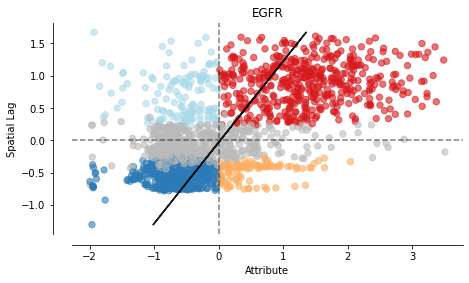

In [14]:
fig, ax = moran_scatterplot(lm, p=0.001)
ax.set_title(marker_names[marker])
plt.show()

In [16]:
m = Moran(y, kw)
m.I

0.3253045997953941